In [1]:
# adjsut the basic logging lovel of notebook
import logging
logging.basicConfig(level=logging.WARNING)

import numpy as np
from auditory_cortex import utils
from auditory_cortex.models import Regression
import matplotlib.pyplot as plt

%matplotlib inline 

### analyzing ensemble model..

In [2]:
from auditory_cortex import saved_corr_dir
import os
import pandas as pd

filepath = os.path.join(saved_corr_dir, 'ensemble_corr_results.csv')
df = pd.read_csv(filepath)

In [3]:
df.shape

(46, 7)

In [37]:
subset = df[df['ensemble_model']>=0.05]

Text(0.5, 1.0, 'Median corr (session-wise) using different models')

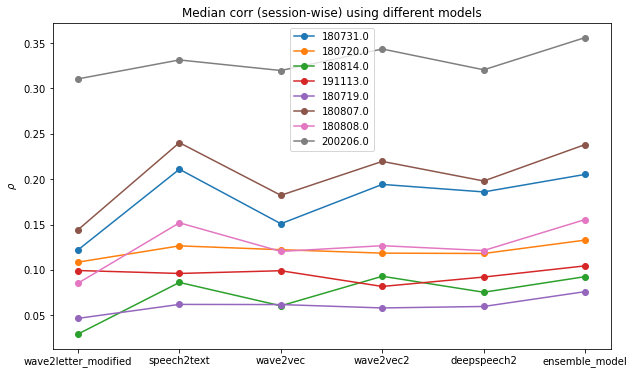

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
for id in subset.index:
    # sess = 
    plt.plot(subset.loc[id, ~subset.columns.str.contains('session')], '-o', label=f"{subset.at[id,'session']}")
plt.ylabel('$\\rho$')
plt.legend(loc='best')
plt.title(f"Median corr (session-wise) using different models")

### model predictions comparison

In [2]:
models = [
    {
        'model_name': 'wave2letter_modified',
        'layer': 6
    },
    {
        'model_name': 'speech2text',
        'layer': 3
    },
    {
        'model_name': 'wave2vec',
        'layer': 8
    },
    {
        'model_name': 'wave2vec2',
        'layer': 7
    },
    {
        'model_name': 'deepspeech2',
        'layer': 2
    },
]

In [4]:
reg_objs = []
session = 200206

for i, model in enumerate(models):
    model_name = model['model_name']
    reg_objs.append(Regression(model_name, load_features=True))


    if i==0:
        test_set = None
    corr_coeff, B, loss, test_set = reg_objs[i].cross_validated_regression(
        session=session, num_lmbdas=10, iterations=1, test_sents=test_set
        )



Loading Neural data for session: 180810 ... Done.
Creating regression obj for: 'wave2letter_modified'
Loading from checkpoint: /depot/jgmakin/data/auditory_cortex/results/pretrained_weights/wave2letter_modified/Wav2letter-epoch=024-val_loss=0.37.ckpt
Loading ANN features at bin-width: 20
Loading Neural data for session: 200206 ... Done.
# of iterations requested: 1, 
                 # of lambda samples per iteration: 10
Itr: 1:
5_fold CV for session: 200206
It takes (on avg.) 4.26 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 3.26 sec/mapping.
It takes (on avg.) 0.13 minutes/iteration...!
Loading Neural data for session: 180810 ... Done.
Creating regression obj for: 'speech2text'
Loading ANN features at bin-width: 20
Loading Neural data for session: 200206 ... Done.
# of iterations requested: 1, 
                 # of lambda samples per iteration: 10
Itr: 1:
5_fold CV for session: 200206
It takes (on avg.) 18.97 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 14.20 s

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading ANN features at bin-width: 20
Loading Neural data for session: 200206 ... Done.
# of iterations requested: 1, 
                 # of lambda samples per iteration: 10
Itr: 1:
5_fold CV for session: 200206
It takes (on avg.) 13.53 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 10.48 sec/mapping.
It takes (on avg.) 0.40 minutes/iteration...!
Loading Neural data for session: 180810 ... Done.
Creating regression obj for: 'deepspeech2'


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.p

Loading ANN features at bin-width: 20
Loading Neural data for session: 200206 ... Done.
# of iterations requested: 1, 
                 # of lambda samples per iteration: 10
Itr: 1:
5_fold CV for session: 200206
It takes (on avg.) 18.40 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 15.98 sec/mapping.
It takes (on avg.) 0.57 minutes/iteration...!


In [5]:
predictions = []

for i, model in enumerate(models):
    predictions.append(reg_objs[i].neural_prediction(session, sent=test_set))
    
spikes = reg_objs[0].get_neural_spikes(session, sents=test_set, numpy=True)

In [53]:
import pandas as pd
model_names = [model['model_name'] for model in models]
model_names.append('ensemble_model')

df = pd.DataFrame(columns=model_names)


In [54]:
model_names

['wave2letter_modified', 'speech2text', 'wave2vec', 'wave2vec2', 'deepspeech2']

### visual comparison...

Text(0.5, 1.0, 'Session-200206, ch-32')

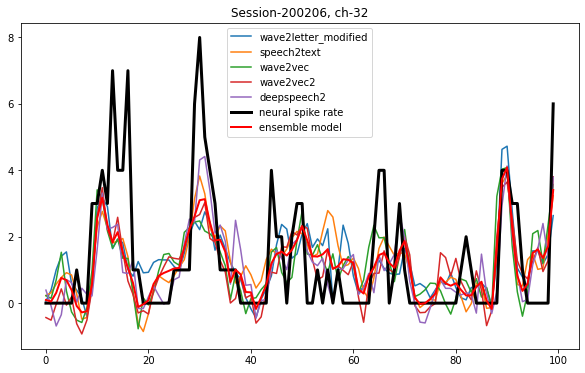

In [29]:
ch = 32

ss = 100
se = 200
plt.subplots(figsize=(10, 6))
ensemble_prediction = []

correlations = []

for i, model in enumerate(models):
    layer = model['layer']
    layer_idx = reg_objs[i].get_layer_index(layer)
    plt.plot(predictions[i][ss:se, ch, layer_idx], label=model['model_name'])
    ensemble_prediction.append(predictions[i][:,:,layer_idx])

    correlations.append(utils.cc_norm(spikes, predictions[i][:, :, layer_idx]))
    

ensemble_prediction = sum(ensemble_prediction)/len(models)
plt.plot(spikes[ss:se, ch], label = 'neural spike rate', c='k', linewidth=3)
plt.plot(ensemble_prediction[ss:se, ch], label='ensemble model', c='r', linewidth=2)

plt.legend(loc='best')
plt.title(f"Session-{session}, ch-{ch}")

In [28]:
corr = utils.cc_norm(spikes, ensemble_prediction)
print(f"Using ensemble of all models   : {np.median(corr):.2f}")

for i, model in enumerate(models):
    print(f"Using {model['model_name']:25}: {np.median(correlations[i]):2.2f}")

Using ensemble of all models   : 0.37
Using wave2letter_modified     : 0.33
Using speech2text              : 0.35
Using wave2vec                 : 0.33
Using wave2vec2                : 0.35
Using deepspeech2              : 0.34


In [47]:
j = 0
layer_idx = reg_objs[j].get_layer_index(models[j]['layer'])
pred = predictions[j][:,:,layer_idx]
for i, model in enumerate(models):
    if i != j:
        layer_idx = reg_objs[i].get_layer_index(models[i]['layer'])
        print(f"Median correlation of {models[j]['model_name']} - {model['model_name']:20}: {np.median(utils.cc_norm(pred, predictions[i][:,:,layer_idx])):.2f}")



Median correlation of wave2letter_modified - speech2text         : 0.74
Median correlation of wave2letter_modified - wave2vec            : 0.77
Median correlation of wave2letter_modified - wave2vec2           : 0.75
Median correlation of wave2letter_modified - deepspeech2         : 0.75


In [49]:
j = 1
layer_idx = reg_objs[j].get_layer_index(models[j]['layer'])
pred = predictions[j][:,:,layer_idx]
for i, model in enumerate(models):
    if i != j:
        layer_idx = reg_objs[i].get_layer_index(models[i]['layer'])
        print(f"Median correlation of {models[j]['model_name']} - {model['model_name']:25}: {np.median(utils.cc_norm(pred, predictions[i][:,:,layer_idx])):.2f}")

Median correlation of speech2text - wave2letter_modified     : 0.74
Median correlation of speech2text - wave2vec                 : 0.78
Median correlation of speech2text - wave2vec2                : 0.81
Median correlation of speech2text - deepspeech2              : 0.77


In [50]:
j = 2
layer_idx = reg_objs[j].get_layer_index(models[j]['layer'])
pred = predictions[j][:,:,layer_idx]
for i, model in enumerate(models):
    if i != j:
        layer_idx = reg_objs[i].get_layer_index(models[i]['layer'])
        print(f"Median correlation of {models[j]['model_name']} - {model['model_name']:25}: {np.median(utils.cc_norm(pred, predictions[i][:,:,layer_idx])):.2f}")

Median correlation of wave2vec - wave2letter_modified     : 0.77
Median correlation of wave2vec - speech2text              : 0.78
Median correlation of wave2vec - wave2vec2                : 0.81
Median correlation of wave2vec - deepspeech2              : 0.73


In [51]:
j = 3
layer_idx = reg_objs[j].get_layer_index(models[j]['layer'])
pred = predictions[j][:,:,layer_idx]
for i, model in enumerate(models):
    if i != j:
        layer_idx = reg_objs[i].get_layer_index(models[i]['layer'])
        print(f"Median correlation of {models[j]['model_name']} - {model['model_name']:25}: {np.median(utils.cc_norm(pred, predictions[i][:,:,layer_idx])):.2f}")

Median correlation of wave2vec2 - wave2letter_modified     : 0.75
Median correlation of wave2vec2 - speech2text              : 0.81
Median correlation of wave2vec2 - wave2vec                 : 0.81
Median correlation of wave2vec2 - deepspeech2              : 0.77


In [52]:
j = 4
layer_idx = reg_objs[j].get_layer_index(models[j]['layer'])
pred = predictions[j][:,:,layer_idx]
for i, model in enumerate(models):
    if i != j:
        layer_idx = reg_objs[i].get_layer_index(models[i]['layer'])
        print(f"Median correlation of {models[j]['model_name']} - {model['model_name']:25}: {np.median(utils.cc_norm(pred, predictions[i][:,:,layer_idx])):.2f}")

Median correlation of deepspeech2 - wave2letter_modified     : 0.75
Median correlation of deepspeech2 - speech2text              : 0.77
Median correlation of deepspeech2 - wave2vec                 : 0.73
Median correlation of deepspeech2 - wave2vec2                : 0.77


In [14]:
model_name2 = models[1]['model_name']
model2 = Regression(model_name=model_name2, load_features=True)

Loading Neural data for session: 180810 ... Done.
Creating regression obj for: 'speech2text'
Loading ANN features at bin-width: 20


In [15]:
corr_coeff2, B2, loss2, test_set2 = model2.cross_validated_regression(
        session=session, num_lmbdas=10, iterations=1
        )

Loading Neural data for session: 200206 ... Done.
# of iterations requested: 1, 
                 # of lambda samples per iteration: 10
Itr: 1:
5_fold CV for session: 200206
It takes (on avg.) 19.35 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 14.28 sec/mapping.
It takes (on avg.) 0.56 minutes/iteration...!


In [ ]:
model_name2 = models[1]['model_name']
model2 = Regression(model_name=model_name2, load_features=True)

### computing neural predictions...

In [31]:
model_name1 = 'wave2letter_modified'
model_name2 = 'speech2text'

In [18]:
sents = np.intersect1d(test_set, test_set2)

In [19]:
pred2 = model2.neural_prediction(session, sent=sents)

In [20]:
pred1 = model1.neural_prediction(session, sent=sents)

In [33]:
spikes = model1.get_neural_spikes(session, sents=sents, numpy=True)

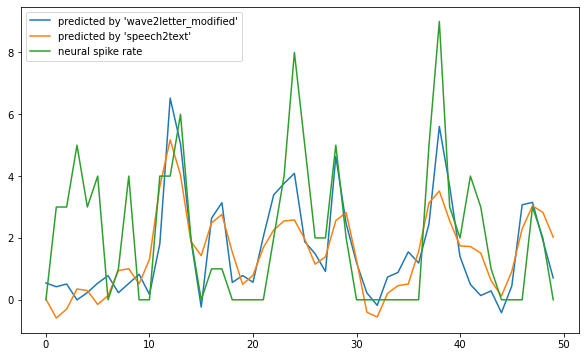

In [73]:
ch = 32
layer = 6
samples = 50
plt.subplots(figsize=(10, 6))
plt.plot(pred1[:samples,ch, layer], label=f"predicted by '{model_name1}'")
plt.plot(pred2[:samples,ch, layer], label=f"predicted by '{model_name2}'")
plt.plot(spikes[:samples,ch], label = 'neural spike rate')


plt.legend(loc='best')

In [50]:
ch = 32
layer1 = 6
layer2 = 2
cc1 = utils.cc_single_channel(spikes[:, ch], pred1[:, ch, layer1])
cc2 = utils.cc_single_channel(spikes[:, ch], pred2[:, ch, layer2])
cc1_2 = utils.cc_single_channel(pred1[:, ch, layer1], pred2[:, ch, layer2])

# using both models
pred = 0.5*(pred1[:, ch, layer1] + pred2[:, ch, layer2])
cc12 = utils.cc_single_channel(spikes[:, ch], pred)

In [51]:
print(f"Corr model1-neural: {cc1[0]:.2f}")
print(f"Corr model2-neural: {cc2[0]:.2f}")
print(f"Corr model1-model2: {cc1_2[0]:.2f}")

print(f"Corr both models: {cc12[0]:.2f}")

Corr model1-neural: 0.60
Corr model2-neural: 0.57
Corr model1-model2: 0.77
Corr both models: 0.63


### all channels

In [64]:
layer1 = 6
layer2 = 2
cc1 = utils.cc_norm(spikes, pred1[:, :, layer1])
cc2 = utils.cc_norm(spikes, pred2[:, :, layer2])
cc1_2 = utils.cc_norm(pred1[:, :, layer1], pred2[:, :, layer2])

# # using both models
pred = 0.5*(pred1[:, :, layer1] + pred2[:, :, layer2])
cc12 = utils.cc_norm(spikes, pred)

In [69]:
print(f"using model1='{model_name1}' and model2 = '{model_name2}':")
print(f"Median Corr model1-neural: {np.median(cc1):.2f}")
print(f"Median Corr model2-neural: {np.median(cc2):.2f}")
print(f"Median Corr model1-model2: {np.median(cc1_2):.2f}")

print(f"Median Corr model1&2 - neural: {np.median(cc12):.2f}")


using model1='wave2letter_modified' and model2 = 'speech2text':
Median Corr model1-neural: 0.32
Median Corr model2-neural: 0.33
Median Corr model1-model2: 0.73
Median Corr model1&2 - neural: 0.35


In [62]:
cc1.shape

(64,)

In [53]:
spikes.shape

(5375, 64)

In [54]:
pred1[:, :, layer1].shape

(5375, 64)

In [47]:
pred = 0.5*(pred1[:, ch, layer1] + pred2[:, ch, layer2])

(5375, 64, 12)

In [48]:
pred2.shape

(5375, 64, 12)

In [44]:
pred12 = 0.5*(pred1 + pred2)

In [ ]:
cc12
print(f"Corr using both models: {}")

In [28]:
model1.spike_datasets

{'200206': <auditory_cortex.dataset.NeuralData at 0x2b84677ac9a0>}

In [8]:
out = model1.neural_prediction(session, sent = test_set[:1])

In [9]:
out.shape

(101, 64, 12)

In [5]:
B.shape

(12, 250, 64)

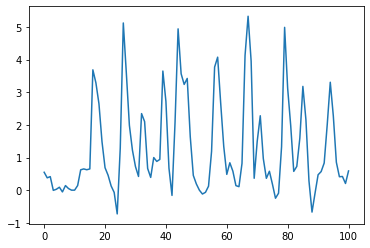

In [13]:
layer = 6
ch = 32
plt.plot(out[:,ch, layer])

In [8]:
import cupy as cp
cp.asnumpy(B)

array([[[ 1.40765561e-01, -5.81274902e-03,  9.63693889e-03, ...,
          4.59744559e-02, -2.36029487e-03, -1.94543217e-02],
        [ 3.41802420e-02, -6.65323912e-02, -1.10624380e-01, ...,
         -5.36735775e-02, -3.37660439e-01, -2.44256722e-01],
        [-9.46103459e-02, -4.32045834e-02,  7.44178717e-02, ...,
          3.40932031e-02,  1.19660778e-01,  1.00345510e-01],
        ...,
        [-2.68087482e-03, -5.75422618e-03, -4.77761055e-03, ...,
         -1.45166489e-02, -1.89513030e-01, -9.81661652e-02],
        [-3.46678159e-01, -2.03725701e-01, -6.16208999e-01, ...,
         -5.22597849e-01, -1.52913945e+00, -1.06863547e+00],
        [-1.64043759e-01, -1.15531918e-02, -2.30150699e-02, ...,
         -6.46172242e-02,  1.13736549e-01,  2.04649921e-01]],

       [[-8.68559682e-03,  1.21577563e-02, -1.58915156e-01, ...,
         -1.60517053e-02,  2.54136238e-02, -5.14478675e-02],
        [-2.92356982e-02, -2.72378301e-02,  2.46482307e-02, ...,
          2.23706658e-02, -7.03302072e